In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from glob import glob
import time
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import datetime

print(torch.cuda.is_available())

True


# Create a Dataloader

In [2]:
IMAGE_W, IMAGE_H = 512, 256

In [3]:
class ImageDataset(Dataset):
    def __init__(self, train_val_test=0):
        self.images = glob(f"./new_ds/{['train', 'val', 'test'][train_val_test]}/*.png")
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=[0.28689554, 0.32513303, 0.28389177], 
                                             std=[0.18696375, 0.19017339, 0.18720214])
        ])
        
    def __len__(self):
        return len(self.images)       
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        # load and transform image
        img_pil = torchvision.io.read_image(img_path) / 255.
        return img_pil

In [4]:
img_ds = ImageDataset()
test_img = img_ds[4]

print(test_img.mean())
print(test_img.std())

tensor(0.2288)
tensor(0.1416)


In [5]:
# print(len(img_ds))

# t1 = time.time()

# for img in img_ds:
#     y = img
    
# print(f"Total time to go through ds: {time.time() - t1:.2f}s")

In [6]:
def visualize(x):
    return x
    device = 'cuda' if x.is_cuda else 'cpu'
    
    x = x.permute(2, 1, 0)
    x *= torch.tensor([0.18696375, 0.19017339, 0.18720214]).to(device)
    x += torch.tensor([0.28689554, 0.32513303, 0.28389177]).to(device)
    return x.permute(2, 1, 0)

min: tensor(0.0392)
max: tensor(0.8078)
mean: tensor(0.2288)


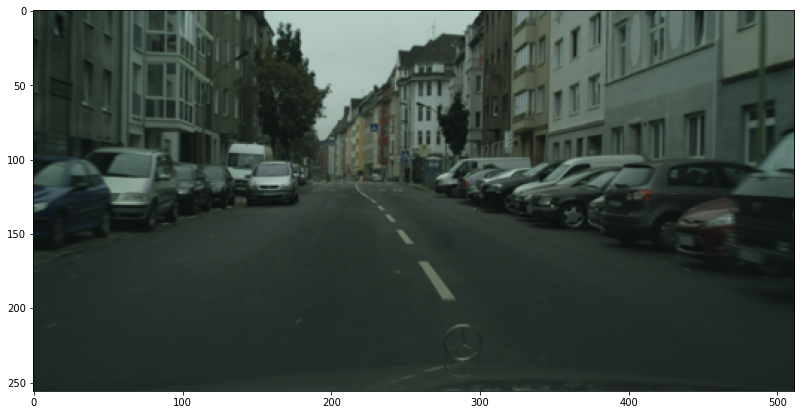

In [7]:
test_img = visualize(img_ds[4]).unsqueeze(0)

print("min:", test_img.min())
print("max:", test_img.max())
print("mean:", test_img.mean())

plt.figure(figsize=(15, 7))
plt.imshow(test_img.squeeze(0).permute(1, 2, 0))

# Create the model

In [8]:
# CURRENT: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
# https://medium.com/@tioluwaniaremu/vgg-16-a-simple-implementation-using-pytorch-7850be4d14a1

# State-of-the-art: https://paperswithcode.com/paper/mask-dino-towards-a-unified-transformer-based-1
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, skip=True, pool=True):
        super().__init__()
        self.skip = skip
        self.do_pool = pool
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=3, 
                              padding=1)
        self.batch1 =  nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                               out_channels=out_channels, 
                               kernel_size=3, 
                               padding=1)
        self.batch2 =  nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, 
                               out_channels=out_channels, 
                               kernel_size=3, 
                               padding=1)
        self.batch3 =  nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        y = self.batch1(x)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.batch2(y)
        y = F.relu(y)
        y = self.conv3(y)
        y = self.batch3(y)
        # check if we want a skip connection
        if self.skip:
            y = torch.add(x, y)
        # check if we want pooling
        if self.do_pool:
            y = self.pool(y)
            
        return F.relu(y)
    
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     kernel_size=2, 
                                     stride=2)
        self.conv = Downsample(in_channels, out_channels, pool=False)
        
    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, depth, initial_channels=16):
        super().__init__()
        self.ds1 = Downsample(in_channels=3, out_channels=initial_channels)
        pow_2 = int(np.log2(initial_channels))
        self.dss = nn.ModuleList([Downsample(in_channels=min(2**x, 512), 
                                             out_channels=min(2**(x+1), 512), 
                                             pool=(x < pow_2 + depth - 1)) for x in range(pow_2, pow_2 + depth)])
        
    def forward(self, x):
        x = self.ds1(x)
        for ds in self.dss:
            x = ds(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, depth, initial_channels):
        super().__init__()
        pow_2 = int(np.log2(initial_channels))
        self.uss = nn.ModuleList([Upsample(in_channels=min(2**(x+1), 512), 
                                           out_channels=min(2**x, 512)) for x in reversed(range(pow_2, pow_2 + depth))])
        self.out_conv = nn.Conv2d(initial_channels, 3, kernel_size=1)
        
    def forward(self, x):
        for us in self.uss:
            x = us(x)
        x = self.out_conv(x)
        return x
    
class Model(nn.Module):
    def __init__(self, depth, intial_channels):
        super().__init__()
        self.encoder = Encoder(depth=depth, initial_channels=intial_channels)
        self.decoder = Decoder(depth=depth, initial_channels=intial_channels)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, 0, 1)
        
DEPTH = 5
INTIAL_CHANNELS = 16

m = Model(depth=DEPTH, intial_channels=INTIAL_CHANNELS).cuda()

print(f"Original\t{test_img.shape}")
out = m(test_img.cuda())
print(f"Model out\t{out.shape}")

Original	torch.Size([1, 3, 256, 512])
Model out	torch.Size([1, 3, 256, 512])


In [9]:
summary(m, input_size=(3, 256, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 3, 256, 512]               0
            Conv2d-2         [-1, 16, 256, 512]             448
       BatchNorm2d-3         [-1, 16, 256, 512]              32
            Conv2d-4         [-1, 16, 256, 512]           2,320
       BatchNorm2d-5         [-1, 16, 256, 512]              32
            Conv2d-6         [-1, 16, 256, 512]           2,320
       BatchNorm2d-7         [-1, 16, 256, 512]              32
         MaxPool2d-8         [-1, 16, 128, 256]               0
        Downsample-9         [-1, 16, 128, 256]               0
           Conv2d-10         [-1, 32, 128, 256]           4,640
      BatchNorm2d-11         [-1, 32, 128, 256]              64
           Conv2d-12         [-1, 32, 128, 256]           9,248
      BatchNorm2d-13         [-1, 32, 128, 256]              64
           Conv2d-14         [-1, 32, 1

# Training Loop

In [10]:
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 0.001

In [11]:
writer = SummaryWriter('runs/version1_d5_max_512' + '_' + datetime.datetime.now().strftime("%d%m-%H%M%S"))

# initialize optimizer 
optim = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, amsgrad=True)

# dataloader 
dl_train = torch.utils.data.DataLoader(ImageDataset(train_val_test=0), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# set up validation datasets and validation images
val_ds = ImageDataset(train_val_test=1)
dl_val = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

val_img1, val_img2, val_img3 = val_ds[14], val_ds[307], val_ds[450]

grid = torch.zeros((3, 256 * 2, 512 * 3))
grid[:, :256, 0:512] = visualize(val_img1)
grid[:, :256, 512:512*2] = visualize(val_img2)
grid[:, :256, 512*2:512*3] = visualize(val_img3)

val_set = torch.stack((val_img1, val_img2, val_img3))

# loss function
criterion = torch.nn.MSELoss()

best_loss, patience = 10000, 0

for epoch in range(EPOCHS):
    loss_sum = 0
    t1 = time.time()
    m.train()
    for i, batch in enumerate(dl_train):
        # zero the gradient
        optim.zero_grad()
        # put the batch on GPU
        batch = batch.cuda()
        # forward pass
        out = m(batch)
        # calculate loss
        loss = criterion(out, batch)
        # backward pass
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_value_(m.parameters(), 1)
        # update the weights
        optim.step()
        # add loss to loss sum
        loss_sum += loss.item()
    
    m.eval()
    
    with torch.no_grad():
        # validation and metric logging
        train_loss = loss_sum / len(dl_train)
        val_loss = 0
        
        # calculate validation loss
        for batch in dl_val:
            batch = batch.cuda()
            # forward pass
            out = m(batch)
            # calculate loss
            loss = criterion(out, batch)
            # add loss to loss sum
            val_loss += loss.item()
        
        # average the validation loss
        val_loss /= len(dl_val)
        # create validation images
        val_out = m(val_set.cuda())
    
        grid[:, 256:, 0:512] = torch.clamp(visualize(val_out[0]), 0, 1)
        grid[:, 256:, 512:512*2] = torch.clamp(visualize(val_out[1]), 0, 1)
        grid[:, 256:, 512*2:512*3] = torch.clamp(visualize(val_out[2]), 0, 1)

        writer.add_image('images', grid, epoch)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Val/train', val_loss, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            patience = 0
        else:
            patience += 1
            
        if patience == 10:
            print("No new best model achieved, stopping here.")
            break
        
        print(f"[{epoch + 1}/{EPOCHS}]\t({time.time() - t1:.2f}s)\tloss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\tpatience: {patience}")

[1/1000]	(117.22s)	loss: 0.0345	val_loss: 0.0714	patience: 0
[2/1000]	(115.58s)	loss: 0.0213	val_loss: 0.0697	patience: 0
[3/1000]	(116.43s)	loss: 0.0206	val_loss: 0.0635	patience: 0
[4/1000]	(114.43s)	loss: 0.0203	val_loss: 0.0710	patience: 1
[5/1000]	(59.15s)	loss: 0.0199	val_loss: 0.0706	patience: 2
[6/1000]	(56.38s)	loss: 0.0196	val_loss: 0.0640	patience: 3
[7/1000]	(54.89s)	loss: 0.0194	val_loss: 0.0677	patience: 4
[8/1000]	(54.44s)	loss: 0.0191	val_loss: 0.0636	patience: 5
[9/1000]	(102.09s)	loss: 0.0188	val_loss: 0.0699	patience: 6
[10/1000]	(78.46s)	loss: 0.0186	val_loss: 0.0691	patience: 7
[11/1000]	(76.60s)	loss: 0.0184	val_loss: 0.0714	patience: 8
[12/1000]	(76.48s)	loss: 0.0183	val_loss: 0.0681	patience: 9
No new best model achieved, stopping here.


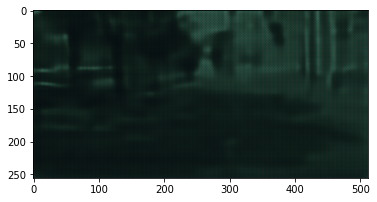

In [12]:
plt.imshow(torch.clamp(visualize(m(img_ds[0].unsqueeze(0).cuda()).squeeze(0).detach().cpu()).permute(1, 2, 0), 0, 1))